GANs are unsupervised learning algorithms with supervised loss.Is this statement correct?

CycleGAN instead of normal GAN because the problem we are dealing here has data of unpaired type

**IMPORTS**

In [1]:
%load_ext tensorboard

In [2]:
!pip install git+https://github.com/tensorflow/examples.git
# to import generator and discriminator    

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-51r3e5_h
  Running command git clone --filter=blob:none -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-51r3e5_h
  Resolved https://github.com/tensorflow/examples.git to commit 2584b5d2a21607f3b913622294c0ddec3fed986f
  Preparing metadata (setup.py) ... - \ done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-2584b5d2a21607f3b913622294c0ddec3fed986f_-py3-none-any.whl size=268428 sha256=afc25cf6b953a51d02dbc766deacb7d96fc4eac2a4eb917030e84f96becd9470
  Stored in directory: /tmp/pip-ephem-wheel-cache-obc33ze3/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... - \ | done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue r

In [3]:
import tensorflow as tf

In [4]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [5]:
from os import listdir

###                                                          CALLING IMAGE_DATA_GENERATOR FOR SETTING UP INPUT PIPELINE





In [6]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

#function is called here but iterators are called where we write training step
#ImageDataGenerator helps us in efficiently reading data as it releases previous batch from RAM before reading next batch

In [7]:
# train_A = datagen.flow_from_directory('/content/A', class_mode='binary',batch_size=10)
# train_B = datagen.flow_from_directory('/content/B', class_mode='binary',batch_size=10)

----------------------------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------

**ALTERNATE WAY OF TAKING IMAGE INPUT BUT FOR LARGER DATASET RESULTED INT RAM OVERFLOW**

TAKING TESTDATA AS INPUT

In [8]:
# Though this data takes input from stream still it overflowed RAM on larger dataset but since train dataset is
# small we can use this as well but try replacing this by image data generator
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
filenames=list()
labels=list()
path='../input/pixelartsmall1/trainA/'
for filename in listdir(path):
   filenames.append(filename)
   labels.append(1)

dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
def _parse_function(filename, label):
    image_string = tf.io.read_file(path+filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

dataset = dataset.map(_parse_function)

2022-01-13 03:39:21.984343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 03:39:22.087257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 03:39:22.087958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 03:39:22.089951: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

**------------------------------------------------------------------------------------------------------------------**

**-------------------------------------------------------------------------------------------------------------------**

# **MODEL CREATION**

In [10]:
!pip install --upgrade keras

     |████████████████████████████████| 1.3 MB 782 kB/s            
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires keras<2.7,>=2.6.0, but you have keras 2.7.0 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.4.0 requires absl-py<0.13,>=0.9, b

**Importing generator and discriminator**

In [11]:
OUTPUT_CHANNELS = 3
from tensorflow_examples.models.pix2pix import pix2pix
# In Instance Normalization -> mean and variance are calculated for each individual channel for each individual sample
Gen_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
Gen_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

Disc_y = pix2pix.discriminator(norm_type='instancenorm', target=False)
Disc_x = pix2pix.discriminator(norm_type='instancenorm', target=False)


# simple unet generator and  unet discriminators are used
# in original implementation unet generator and resnet discriminator is used

# insted of batch, instance normalisation is used (as per paper)

**Setting up all loss functions**

In [12]:
LAMBDA = 10
#to be multiplied with cyclic loss as per paper

In [13]:
#Binary cross entropy loss is considered (for losses of both GANs)
loss_BinaryCross = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Generator and Discriminator losses are calculated in same way as in tutorial of GANs
![https://drive.google.com/file/d/1pz4em0aasuUIJvZnQmL_urlNBl1qUJTe/view?usp=sharing]

In [14]:
def discriminator_loss(real, generated):
  real_loss = loss_BinaryCross(tf.ones_like(real), real)
  generated_loss = loss_BinaryCross(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_BinaryCross(tf.ones_like(generated), generated)

# cyclic loss to ensure mapping can be established between two GANs
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * loss *0.5

**Optimisers : For BackPropagation on gradients and modifying weights**

In [15]:
Gen_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
Gen_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
Disc_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
Disc_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# **RESTORING THE LAST CHECKPOINT :**

In [16]:
# Upload your checkpoints as datasets and enter their path here
#Most recent checkpoints will be loaded
#If no checkpoints exists this wont show error
checkpoint_path = "../input/checkpoint-10-epochs-largerdataset/checkpoints/train/"

ckpt = tf.train.Checkpoint(Gen_g=Gen_g,
                           Gen_f=Gen_f,
                           Disc_x=Disc_x,
                           Disc_y=Disc_y,
                           Gen_g_optimizer=Gen_g_optimizer,
                           Gen_f_optimizer=Gen_f_optimizer,
                           Disc_x_optimizer=Disc_x_optimizer,
                           Disc_y_optimizer=Disc_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


# **MODEL**

**generate_images -> to generate image with current weights of generator**

Used while generating on test data

In [17]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [18]:
# Define our metrics for monitoring loss using tensorboard
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_loss1 = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)


**Logic For Training = True**

Some neural network layers behave differently during training and inference, for example Dropout and BatchNormalization layers. For example
During training, dropout will randomly drop out units and correspondingly scale up activations of the remaining units.
During inference, it does nothing (since you usually don't want the randomness of dropping out units here).
The training argument lets the layer know which of the two "paths" it should take. If you set this incorrectly, your network might not behave as expected.

In [19]:
@tf.function
def train_step(real_normal,real_pixel):
  #Gradient tape records the operations on variables being watched and allow us to perform automatic differentiation
  with tf.GradientTape(persistent=True) as tape:
    #pixel = Y and normal=X
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_pixel = Gen_g(real_normal, training=True)
    cycled_normal = Gen_f(fake_pixel, training=True)

    fake_normal = Gen_f(real_pixel, training=True)
    cycled_pixel = Gen_g(fake_normal, training=True)

    #  for identity loss. -> if image of target class is given as input it should return same (equivalent) image
    same_normal = Gen_f(real_normal, training=True)
    same_pixel = Gen_g(real_pixel, training=True)

    disc_real_normal = Disc_x(real_normal, training=True)
    disc_real_pixel = Disc_y(real_pixel, training=True)

    disc_fake_normal = Disc_x(fake_normal, training=True)
    disc_fake_pixel = Disc_y(fake_pixel, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_pixel)
    gen_f_loss = generator_loss(disc_fake_normal)
    
    total_cycle_loss = calc_cycle_loss(real_pixel, cycled_pixel) + calc_cycle_loss(real_normal, cycled_normal)
    
    # Total generator loss = adversarial loss + cycle loss
    #identity loss is added because we want to have similarities bw input and generated images as close as possible
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_pixel,same_pixel)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_normal,same_normal)

    disc_x_loss = discriminator_loss(disc_real_normal, disc_fake_normal)
    disc_y_loss = discriminator_loss(disc_real_pixel, disc_fake_pixel)
    
    train_loss(total_gen_g_loss)
    train_loss1(total_gen_f_loss)
  # Calculate --> gradients for generator and discriminator  (tape.gradient(y,x) implies dy/dx)
  Gen_g_gradients = tape.gradient(total_gen_g_loss, 
                                        Gen_g.trainable_variables)
  Gen_f_gradients = tape.gradient(total_gen_f_loss, 
                                        Gen_f.trainable_variables)
  
  Disc_x_gradients = tape.gradient(disc_x_loss, 
                                            Disc_x.trainable_variables)
  Disc_y_gradients = tape.gradient(disc_y_loss, 
                                            Disc_y.trainable_variables)
  
  # Apply the gradients to the optimizer (gradient descent to update the weights)
  # the resources held by a GradientTape are released as soon as GradientTape.gradient() method is called. thats why persistent is set to True because the tape is used more than ones
  Gen_g_optimizer.apply_gradients(zip(Gen_g_gradients, 
                                            Gen_g.trainable_variables))

  Gen_f_optimizer.apply_gradients(zip(Gen_f_gradients, 
                                            Gen_f.trainable_variables))
  
  Disc_x_optimizer.apply_gradients(zip(Disc_x_gradients,
                                                Disc_x.trainable_variables))
  
  Disc_y_optimizer.apply_gradients(zip(Disc_y_gradients,
                                                Disc_y.trainable_variables))

# **TRAINING STEP:**

In [20]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/traing'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_log_dir1 = 'logs/gradient_tape/' + current_time + '/trainf'
train_summary_writer1 = tf.summary.create_file_writer(train_log_dir1)

In [21]:
import numpy as np
def preprocess_image_train(image):
  #jitter
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # randomly cropping to 256 x 256 x 3
  image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  # random mirroring
  image = tf.image.random_flip_left_right(image)
  #   normalise
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image


# 1 epoch -> 1 time model has seen entire dataset
# 1 iteration -> model has seen 1 batch of data and has updated weights after seeing that batch of data
#Batch size of 10 is considered here 
epochs=40
for epoch in range (0,epochs):
    start=time.time()  
    train_A = datagen.flow_from_directory('../input/dataset20-pixelart/new data/A', class_mode='binary',batch_size=10)
    train_B = datagen.flow_from_directory('../input/bimages/B', class_mode='binary',batch_size=10)
    a=train_A.next()
    b=train_B.next()
    i=0
    while a and b:
       if i>245 :
          break
       i+=1
       j=0
       for j in range (0,len(a[0])):
         a[0][j]=preprocess_image_train(a[0][j])
       for j in range (0,len(b[0])):
         b[0][j]=preprocess_image_train(b[0][j])
       train_step(a[0],b[0])
       a=train_A.next()  #fetching iterator to next batch of image A
       b=train_B.next()  #fetching iterator to next batch of image B
        
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
    with train_summary_writer1.as_default():
        tf.summary.scalar('loss', train_loss1.result(), step=epoch)

    print('Time taken for epoch {} is {} sec\n'.format(epoch,time.time()-start))
    if epoch % 2 == 0:
      checkpoint_path = "./checkpoints/train"
      ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
      ckpt_save_path = ckpt_manager.save()
      print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))
      clear_output(wait=True)

Found 2461 images belonging to 1 classes.
Found 6309 images belonging to 1 classes.
Time taken for epoch 39 is 225.4053933620453 sec



In [22]:
#running tensorboard
# %tensorboard --logdir /logs/gradient_tape/20220112-132013/traing
# !kill 369

# **TESTING STEP:**

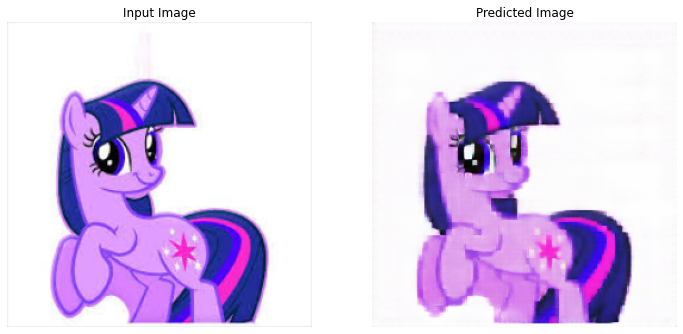

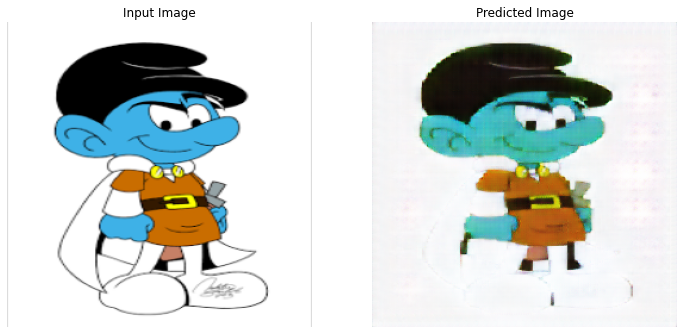

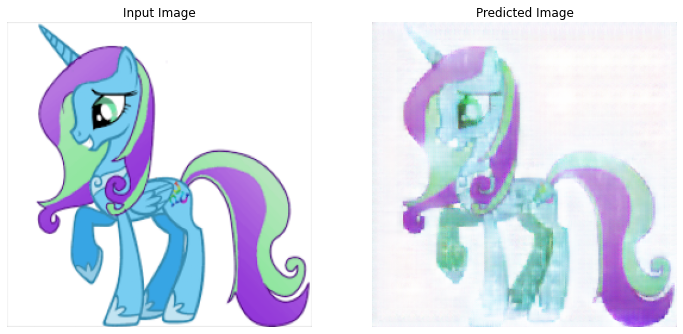

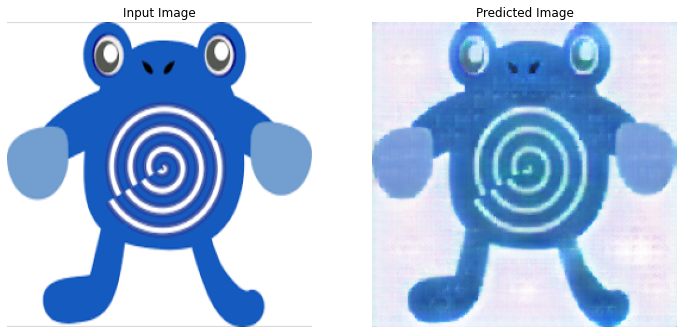

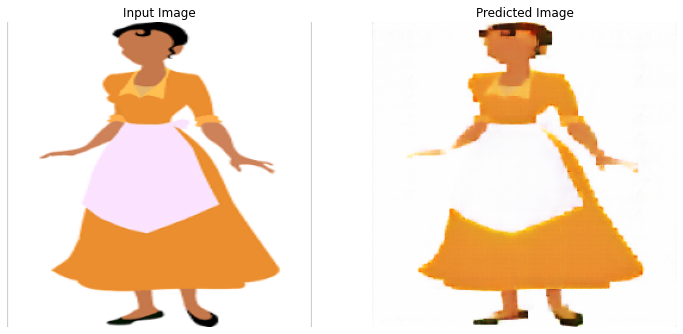

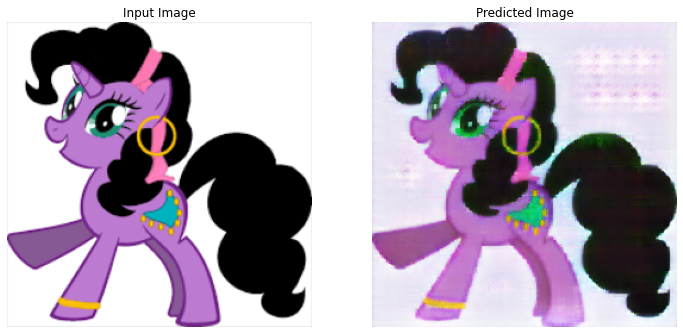

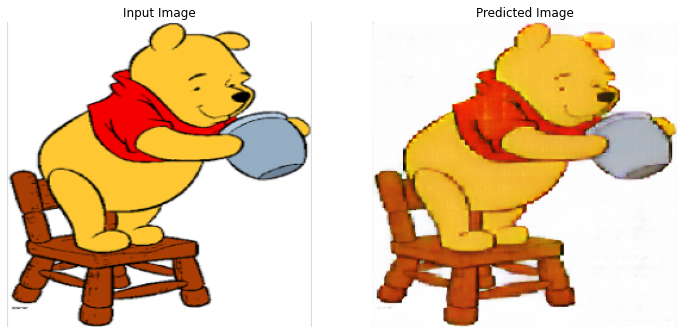

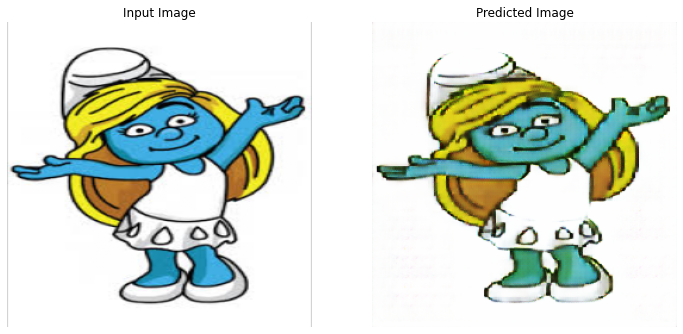

In [23]:
def preprocess_test(image, label):
  image = tf.image.resize(image,[256,256])
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image
train_A = dataset.cache().map(
    preprocess_test, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)
for inp in train_A.take(8):
  generate_images(Gen_g, inp)

**What can be done to improve results:->**

**1)Obtain better dataset  (By scrapping websites)**

**2)experimenting with hyper paramenters (batch size,lambda,alpha(learning rate),epochs etc)**

**3)Trying different models for generator and discriminator (like resnet etc)**

**4)Trying different optimisers**

**5)Setting up some sort of evaluation of model**